## Installing Julia

- Download and install the current stable release of Julia for your operating
system. To that end, follow the instructions at https://julialang.org/downloads/.
- Download and install VSCode by following the instructions at
https://code.visualstudio.com/.
- Start VSCode and install the Julia extension (Preferences $\rightarrow$ Extensions).
Type `julia' into the searchbar and install the Julia extension
- Restart VSCode.

In [1]:
using Pkg
pkg"activate @CZS"
pkg"add Zygote, ChainRulesCore, Unitful, Measurements"

  Activating project at `~/.julia/environments/CZS`
   Resolving package versions...
  No Changes to `~/.julia/environments/CZS/Project.toml`
  No Changes to `~/.julia/environments/CZS/Manifest.toml`


## Solving the Two Language Problem

### Two Language Problem
- Prototype in an easy-to-use high-level (dynamic) language (Python, MATLAB, ...)
- Rewrite performance critical components in a hard-to-use low-level (static) language (C, Fortran)

### Solutions
- Vectorization (MATLAB, Python/NumPy, . . . )
- Dynamic language with fast enough core functionality (for-loops, . . . ) that performance critical libraries can be written in the language itself

## Goals for today:
- Julia intro for beginners
- Be exposed to some neat features of the Julia ecosystem
- Get a rough idea of the concepts that make Julia unique and powerful
    - **Multiple Dispatch & Type Inference**
- Get ready for the SciML tutorial!

## Big picture:
- JIT is getting popular for scientific computing:
    - C++ has Cling
    - Python has Pypy, Pyston, Pyjion, Numba, Jax, PyTorch, (Python itself soon), Mojo(?)

### Source of performance
- Type information (when you write those types for C++ compiler)
- $\rightarrow$ Specialized compilation (why JIT is popular: compile more native code)

### Maybe, just maybe...
Maybe a language designed with JIT for scientific computing would be nice?

- Eager JIT (as opposed to profiling based)
- Auto specialize on function input types (speed doesn't come from type annotation)

For this you need concept of types, and a way to decide what to compile

## Types

### Variables have types in Julia

In [2]:
typeof(1.0f0)

Float32

In [3]:
typeof([1, 2, 3])

Vector{Int64} (alias for Array{Int64, 1})

### Types are partially ordered

In [4]:
supertype(Float64)

AbstractFloat

In [5]:
supertype(AbstractFloat)

Real

In [6]:
Float64 <: AbstractFloat <: Real <: Number
#       ^---is a subtype of

true

### Types can be parametric

In [7]:
Vector{T} where T<:Number

Vector{T} where T<:Number (alias for Array{T, 1} where T<:Number)

In [8]:
Vector{Float64} <: AbstractVector{<:Real}

true

## Multiple Dispatch

### Multiple = "look at types of all arguments"

In [9]:
f(x) = "Anything one thing"
f(x, y) = "Anything two things"
f(xs...) = "Any number of Anythings"

f (generic function with 3 methods)

In [10]:
f(1)

"Anything one thing"

In [11]:
f(1, 3)

"Anything two things"

### Function call runs the most specific method

In [12]:
f(x::Number, y) = "a Number and an Anything"
f(x::Number, y::Number)= "two Numbers"

f (generic function with 5 methods)

In [13]:
f(1, "")

"a Number and an Anything"

In [14]:
f(1, 2)

"two Numbers"

In [15]:
f([], [])

"Anything two things"

In [16]:
f(x, y::Int) = "this cause ambiguity"
f(1,2)

LoadError: MethodError: f(::Int64, ::Int64) is ambiguous.

Candidates:
  f([90mx[39m::[1mNumber[22m, [90my[39m::[1mNumber[22m)
[90m    @[39m [90mMain[39m [90m[4mIn[12]:2[24m[39m
  f([90mx[39m::[1mNumber[22m, [90my[39m)
[90m    @[39m [90mMain[39m [90m[4mIn[12]:1[24m[39m
  f([90mx[39m, [90my[39m::[1mInt64[22m)
[90m    @[39m [90mMain[39m [90m[4mIn[16]:1[24m[39m

Possible fix, define
  f(::Number, ::Int64)


## Higher-order functions

In [17]:
A = rand(5)

5-element Vector{Float64}:
 0.8089351596612074
 0.7464717673847994
 0.22022273150216964
 0.04421362703723353
 0.8323783371792466

In [18]:
findall(<(0.5), A)

2-element Vector{Int64}:
 3
 4

In [19]:
mapreduce(ceil, +, A)

5.0

## Forward (overload) AD done quick

[Notes from MIT 18.337](https://book.sciml.ai/notes/08-Forward-Mode_Automatic_Differentiation_(AD)_via_High_Dimensional_Algebras/)

### Subtype a Dual <: Number dynamically

In [20]:
subtypes(Number)

2-element Vector{Any}:
 Complex
 Real

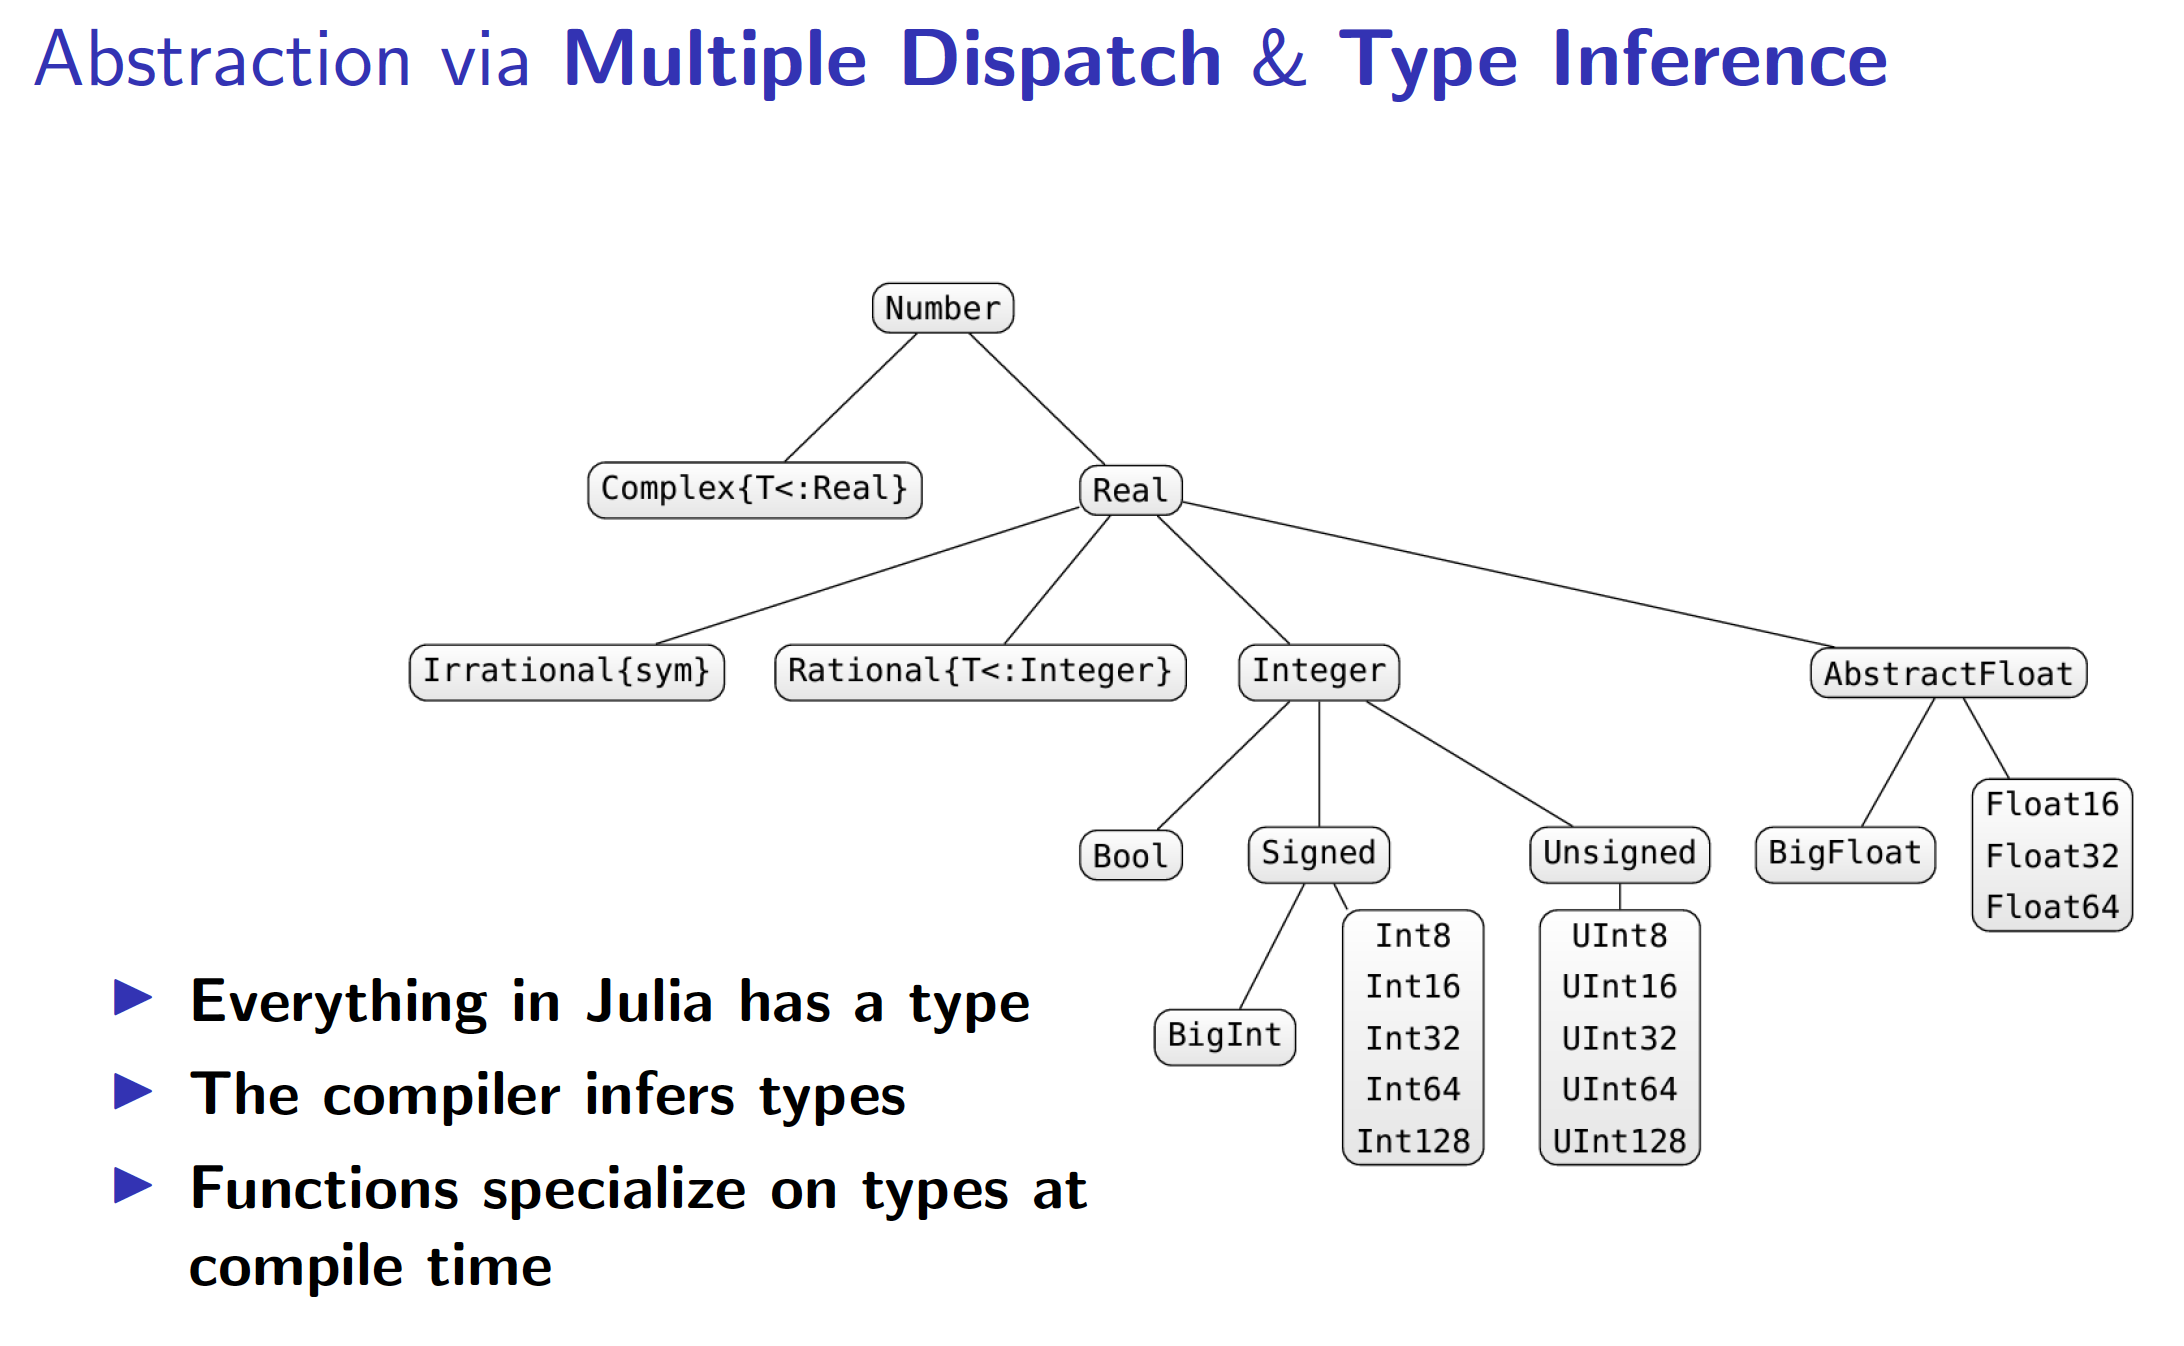

In [21]:
struct MyDual{T} <: Number
    val::T
    der::T
end

In [22]:
subtypes(Number)

3-element Vector{Any}:
 Complex
 MyDual
 Real

### Extend (specialize) basic Julia functions for AD

In [23]:
Base.:+(f::MyDual, g::MyDual) = MyDual(f.val + g.val, f.der + g.der)
Base.:+(f::MyDual, g::Number) = MyDual(f.val + g, f.der)
Base.:+(f::Number, g::MyDual) = f + g
Base.:*(f::MyDual, g::MyDual) = MyDual(f.val*g.val, f.der*g.val + f.val*g.der)
Base.:*(α::Number, f::MyDual) = MyDual(f.val * α, f.der * α)
Base.:*(f::MyDual, α::Number) = α * f

# ...
# ..
# .

In [24]:
x = MyDual(0.1, 1.0)

MyDual{Float64}(0.1, 1.0)

In [25]:
x + x

MyDual{Float64}(0.2, 2.0)

In [26]:
x*x

MyDual{Float64}(0.010000000000000002, 0.2)

You can imagine the rest...

### AD at different abstraction level

In [27]:
using Zygote, ChainRulesCore

my_cos(x) = 1 - x^2/2
my_sin(x) = x - x^3/6

my_sin (generic function with 1 method)

If you naively take derivative for `cos`:

In [28]:
Zygote.gradient(my_cos, 0.8) # BAD

(-0.8,)

In [29]:
my_cos(x) = 1 - x^2/2
@scalar_rule(my_cos(x), -my_sin(x))

In [30]:
Zygote.gradient(my_cos, 0.8) # much better

(-0.7146666666666667,)

In [31]:
my_sin(0.8)

0.7146666666666667

### You can also specialize on function type!

In [32]:
function addone(a::AbstractArray)
    b = similar(a)
    b .= a .+ 1
    return sum(b)
end

a = [2.0, 3.0, 5.0]
gradient(addone, a)

LoadError: Mutating arrays is not supported -- called copyto!(Vector{Float64}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


In [33]:
function addone(a::AbstractArray)
    b = similar(a)
    b .= a .+ 1
    return sum(b)
end

function ChainRulesCore.rrule(::typeof(addone), a)
    y = addone(a)
    function addone_pullback(ȳ)
        return NoTangent(), ones(length(a))
    end
    return y, addone_pullback
end

gradient(addone, a)

([1.0, 1.0, 1.0],)

## Composability

There's a great talk on this:

The Unreasonable Effectiveness of Multiple Dispatch | Stefan Karpinski

(https://www.youtube.com/watch?v=kc9HwsxE1OY)

In [34]:
using Unitful

In [35]:
m = 2u"kg"

2 kg

In [36]:
using Measurements

In [37]:
a1 = 2 ± 0.3
a2 = 1.3 ± 0.1

a1 * a2

2.6 ± 0.44

In [38]:
m_obs = (m ± 0.1u"kg")
a_obs = (1.3 ± 0.3)u"m/s^2"

1.3 ± 0.3 m s⁻²

In [39]:
F_obs = m_obs * a_obs

2.6 ± 0.61 kg m s⁻²

In [40]:
uconvert(u"N", F_obs)

2.6 ± 0.61 N

## Broadcast has a syntax

In [41]:
A = [1.1, 2.2, 3.3]
B = [4.4, 5.5, 6.6]


(A .+ B) .^ 2

3-element Vector{Float64}:
 30.25
 59.290000000000006
 98.00999999999998

In [42]:
@. (A + my_sin(B)) ^ 2

3-element Vector{Float64}:
   75.6436071111112
  401.1675173611112
 1445.216256

![image](https://github.com/oschulz/julia-course/assets/5306213/fbd16cb9-8fe5-495e-98c4-9e8146a9fc5c)


In [43]:
f() = (1 + sin(3)) * ary[4]

f (generic function with 7 methods)

In [44]:
@code_lowered f()

CodeInfo(
1 ─ %1 = Main.sin(3)
│   %2 = 1 + %1
│   %3 = Base.getindex(Main.ary, 4)
│   %4 = %2 * %3
└──      return %4
)

In [45]:
function g()
    i = 2+3
    @show i
    
    return nothing
end

g() # macro sees source code as data structure

i = 5


In [46]:
@code_llvm debuginfo=:none f()

# @code_native f()

define nonnull {}* @julia_f_4626() #0 {
top:
  %0 = alloca [2 x {}*], align 8
  %gcframe3 = alloca [3 x {}*], align 16
  %gcframe3.sub = getelementptr inbounds [3 x {}*], [3 x {}*]* %gcframe3, i64 0, i64 0
  %.sub = getelementptr inbounds [2 x {}*], [2 x {}*]* %0, i64 0, i64 0
  %1 = bitcast [3 x {}*]* %gcframe3 to i8*
  call void @llvm.memset.p0i8.i32(i8* noundef nonnull align 16 dereferenceable(24) %1, i8 0, i32 24, i1 false)
  %2 = call {}*** inttoptr (i64 7163826428 to {}*** (i64)*)(i64 261) #2
  %3 = bitcast [3 x {}*]* %gcframe3 to i64*
  store i64 4, i64* %3, align 16
  %4 = load {}**, {}*** %2, align 8
  %5 = getelementptr inbounds [3 x {}*], [3 x {}*]* %gcframe3, i64 0, i64 1
  %6 = bitcast {}** %5 to {}***
  store {}** %4, {}*** %6, align 8
  %7 = bitcast {}*** %2 to {}***
  store {}** %gcframe3.sub, {}*** %7, align 8
  %8 = load atomic {}*, {}** @0 unordered, align 8
  %.not = icmp eq {}* %8, null
  br i1 %.not, label %notfound, label %found

notfound:                        

### Loop Fusion and SIMD Vectorization

Back to having syntax for broadcasting, some advantages

In [47]:
# without fusion you waste O(N) temporary RAM
foo(X, Y) = (X .+ Y) .^ 2 
@code_llvm debuginfo=:none foo(A, B)

# we look for evidence that there's SIMD vectorization going on

define nonnull {}* @julia_foo_4649({}* noundef nonnull align 16 dereferenceable(40) %0, {}* noundef nonnull align 16 dereferenceable(40) %1) #0 {
top:
  %2 = alloca [4 x {}*], align 8
  %gcframe174 = alloca [4 x {}*], align 16
  %gcframe174.sub = getelementptr inbounds [4 x {}*], [4 x {}*]* %gcframe174, i64 0, i64 0
  %.sub = getelementptr inbounds [4 x {}*], [4 x {}*]* %2, i64 0, i64 0
  %3 = bitcast [4 x {}*]* %gcframe174 to i8*
  call void @llvm.memset.p0i8.i32(i8* noundef nonnull align 16 dereferenceable(32) %3, i8 0, i32 32, i1 false)
  %4 = alloca [1 x [1 x i64]], align 8
  %5 = alloca [1 x [1 x i64]], align 8
  %6 = call {}*** inttoptr (i64 7163826428 to {}*** (i64)*)(i64 261) #5
  %7 = bitcast [4 x {}*]* %gcframe174 to i64*
  store i64 8, i64* %7, align 16
  %8 = load {}**, {}*** %6, align 8
  %9 = getelementptr inbounds [4 x {}*], [4 x {}*]* %gcframe174, i64 0, i64 1
  %10 = bitcast {}** %9 to {}***
  store {}** %8, {}*** %10, align 8
  %11 = bitcast {}*** %6 to {}***
  store 

  %30 = getelementptr inbounds [1 x [1 x i64]], [1 x [1 x i64]]* %4, i64 0, i64 0, i64 0
  store i64 %.sroa.027.0, i64* %30, align 8
  %31 = call nonnull {}* inttoptr (i64 4374888636 to {}* ({}*, i64)*)({}* inttoptr (i64 4789499904 to {}*), i64 %.sroa.027.0)
  %32 = bitcast {}* %31 to { i8*, i64, i16, i16, i32 }*
  %33 = getelementptr inbounds { i8*, i64, i16, i16, i32 }, { i8*, i64, i16, i16, i32 }* %32, i64 0, i32 1
  %34 = load i64, i64* %33, align 8
  %.not.not = icmp eq i64 %34, %.sroa.027.0
  br i1 %.not.not, label %L58, label %L160

L58:                                              ; preds = %L31
  %.not = icmp eq {}* %31, %0
  br i1 %.not, label %L74, label %L61

L61:                                              ; preds = %L58
  %35 = bitcast {}* %31 to i8**
  %36 = load i8*, i8** %35, align 8
  %37 = bitcast {}* %0 to i8**
  %38 = load i8*, i8** %37, align 8
  %.not46.not = icmp eq i8* %36, %38
  br i1 %.not46.not, label %L69, label %L74

L69:                                  

  store <2 x double> %68, <2 x double>* %71, align 8
  %72 = getelementptr inbounds double, double* %70, i64 2
  %73 = bitcast double* %72 to <2 x double>*
  store <2 x double> %69, <2 x double>* %73, align 8
  %index.next = add nuw i64 %index, 4
  %74 = icmp eq i64 %index.next, %n.vec
  br i1 %74, label %middle.block, label %vector.body

middle.block:                                     ; preds = %vector.body
  %cmp.n = icmp eq i64 %.sroa.027.0, %n.vec
  br i1 %cmp.n, label %L170, label %scalar.ph

scalar.ph:                                        ; preds = %middle.block, %vector.memcheck, %L125.preheader
  %bc.resume.val = phi i64 [ %n.vec, %middle.block ], [ 0, %L125.preheader ], [ 0, %vector.memcheck ]
  br label %L125

L125.us51.preheader:                              ; preds = %L125.lr.ph.L125.lr.ph.split_crit_edge
  br i1 %min.iters.check154, label %scalar.ph92, label %vector.memcheck77

vector.memcheck77:                                ; preds = %L125.us51.preheader
  %scevgep7

  %conflict.rdx119 = or i1 %found.conflict115, %found.conflict118
  br i1 %conflict.rdx119, label %scalar.ph121, label %vector.ph124

vector.ph124:                                     ; preds = %vector.memcheck106
  %n.vec126 = and i64 %.sroa.027.0, 9223372036854775804
  %.pre173 = load double, double* %53, align 8
  br label %vector.body122

vector.body122:                                   ; preds = %vector.body122, %vector.ph124
  %index129 = phi i64 [ 0, %vector.ph124 ], [ %index.next136, %vector.body122 ]
  %broadcast.splatinsert132 = insertelement <2 x double> poison, double %.pre173, i64 0
  %broadcast.splat133 = shufflevector <2 x double> %broadcast.splatinsert132, <2 x double> poison, <2 x i32> zeroinitializer
  %88 = getelementptr inbounds double, double* %55, i64 %index129
  %89 = bitcast double* %88 to <2 x double>*
  %wide.load130 = load <2 x double>, <2 x double>* %89, align 8
  %90 = getelementptr inbounds double, double* %88, i64 2
  %91 = bitcast double* %90 to <2 x do

  %cmp.n159 = icmp eq i64 %.sroa.027.0, %n.vec157
  br i1 %cmp.n159, label %L170, label %scalar.ph152

scalar.ph152:                                     ; preds = %middle.block151, %vector.memcheck137, %L125.us.us.preheader
  %bc.resume.val158 = phi i64 [ %n.vec157, %middle.block151 ], [ 0, %L125.us.us.preheader ], [ 0, %vector.memcheck137 ]
  br label %L125.us.us

L125.us.us:                                       ; preds = %L125.us.us, %scalar.ph152
  %value_phi1150.us.us = phi i64 [ %116, %L125.us.us ], [ %bc.resume.val158, %scalar.ph152 ]
  %111 = load double, double* %53, align 8
  %112 = load double, double* %55, align 8
  %113 = fadd double %111, %112
  %114 = fmul double %113, %113
  %115 = getelementptr inbounds double, double* %57, i64 %value_phi1150.us.us
  store double %114, double* %115, align 8
  %116 = add nuw nsw i64 %value_phi1150.us.us, 1
  %exitcond56.not = icmp eq i64 %116, %.sroa.027.0
  br i1 %exitcond56.not, label %L170, label %L125.us.us

L125.us:                

In [48]:
@code_native debuginfo=:none foo(A, B)

	.section	__TEXT,__text,regular,pure_instructions
	.build_version macos, 12, 0
	.globl	_julia_foo_4669                 ; -- Begin function julia_foo_4669
	.p2align	2
_julia_foo_4669:                        ; @julia_foo_4669
	.cfi_startproc
; %bb.0:                                ; %top
	sub	sp, sp, #144
	stp	x24, x23, [sp, #80]             ; 16-byte Folded Spill
	stp	x22, x21, [sp, #96]             ; 16-byte Folded Spill
	stp	x20, x19, [sp, #112]            ; 16-byte Folded Spill
	stp	x29, x30, [sp, #128]            ; 16-byte Folded Spill
	.cfi_def_cfa_offset 144
	.cfi_offset w30, -8
	.cfi_offset w29, -16
	.cfi_offset w19, -24
	.cfi_offset w20, -32
	.cfi_offset w21, -40
	.cfi_offset w22, -48
	.cfi_offset w23, -56
	.cfi_offset w24, -64
	mov	x22, x1
	mov	x23, x0
	movi	v0.2d, #0000000000000000
	stp	q0, q0, [sp, #16]
	mov	x8, #20732
	movk	x8, #43775, lsl #16
	movk	x8, #1, lsl #32
	mov	w0, #261
	blr	x8
	mov	x19, x0
	mov	w8, #8
	str	x8, [sp, #16]
	ldr	x8, [x0]
	str	x8, [sp, #24]
	add	x8, sp,

LBB0_28:                                ; %L125.us.us
                                        ; =>This Inner Loop Header: Depth=1
	ldr	d0, [x8]
	ldr	d1, [x9]
	fadd	d0, d0, d1
	fmul	d0, d0, d0
	str	d0, [x10], #8
	subs	x12, x12, #1
	b.ne	LBB0_28
	b	LBB0_50
LBB0_29:                                ; %vector.memcheck77
	mov	x11, #0
	lsl	x12, x21, #3
	add	x13, x9, #8
	add	x14, x8, x12
	cmp	x10, x14
	cset	w14, lo
	add	x15, x10, x12
	cmp	x8, x15
	cset	w12, lo
	and	w14, w14, w12
	cmp	x10, x13
	cset	w12, lo
	cmp	x9, x15
	cset	w13, lo
	tbnz	w14, #0, LBB0_34
; %bb.30:                               ; %vector.memcheck77
	and	w12, w12, w13
	tbnz	w12, #0, LBB0_34
; %bb.31:                               ; %vector.ph95
	and	x11, x21, #0x7ffffffffffffffc
	ldr	d0, [x9]
	add	x12, x8, #16
	add	x13, x10, #16
	dup	v0.2d, v0.d[0]
	mov	x14, x11
LBB0_32:                                ; %vector.body93
                                        ; =>This Inner Loop Header: Depth=1
	ldp	q1, q2, [x12, #-16]
	fadd	v1.2d

	movk	x0, #1, lsl #32
	mov	w2, #1
	blr	x8
Lloh8:
	adrp	x8, _ijl_throw@GOTPAGE
Lloh9:
	ldr	x8, [x8, _ijl_throw@GOTPAGEOFF]
	blr	x8
	.loh AdrpLdrGot	Lloh0, Lloh1
	.loh AdrpLdrGot	Lloh8, Lloh9
	.loh AdrpLdrGot	Lloh6, Lloh7
	.loh AdrpLdrGot	Lloh4, Lloh5
	.loh AdrpLdrGot	Lloh2, Lloh3
	.cfi_endproc
                                        ; -- End function
.subsections_via_symbols


## Jerry Ling's presentation on real-time distributed computing
https://docs.google.com/presentation/d/1DglCCNGpioATq8QXX0NBhJq0XCbSCgvLKQYYgGAV7pw/edit#slide=id.g23f37606b29_50_299

## Many thanks to Jerry Ling, Gaurav Arya, Flemming Holtorf and Chris Rackauckas for their help in preparing this tutorial!